In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from scipy import constants as c
c.Msun = 1.989e30

from pycbc import fft, types
from pycbc.waveform import get_fd_waveform, get_td_waveform, fd_approximants, apply_fd_time_shift
from pycbc.waveform.utils import fd_to_td

from copy import deepcopy

import sys
sys.path.append("../")
import GSHEWaveform

# Functions to turn on and off custom plotting
def default_mplstyle():
    mpl.rcParams.update(mpl.rcParamsDefault)
    
def custom_mplstyle():
    mpl.style.use("../plot_style.txt")
    
%load_ext autoreload
%autoreload 2

We want to choose a signal covering frequency range

\begin{equation}
f_\min = 40~\mathrm{Hz} \leq f \leq f_\max = 1024~\mathrm{Hz},
\end{equation}

and assume the background mass to be $M = 5\times10^4 M_\odot$.

In [2]:
f_min = 40
f_max = 1024
M = 5e4

over this range we get the following $\epsilon$:

<IPython.core.display.Javascript object>


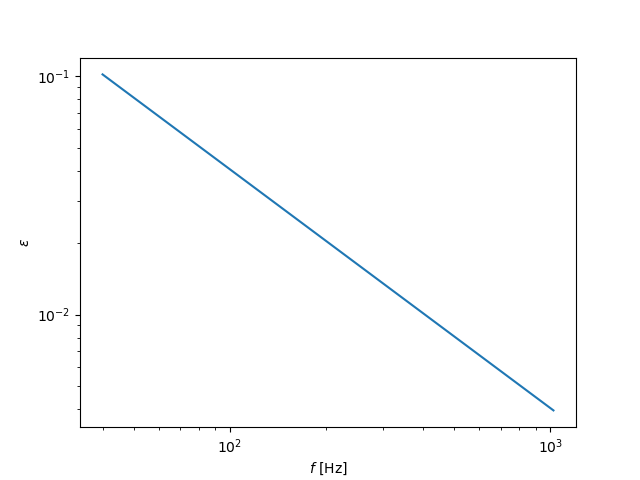

In [3]:
fs = np.linspace(f_min, f_max, 1000)

plt.figure()
plt.plot(fs, GSHEWaveform.epsilon(fs, M))
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$f~[\mathrm{Hz}]$")
plt.ylabel(r"$\epsilon$")
plt.show()

So at the lower frequency-range we get a reasonable value of $\epsilon \approx 0.1$.

We pick the ``IMPPhenomXP`` waveform-approximant with some arbitrary parameterisation. We choose frequency resolution $\delta f = 0.001$. Because of the Fourier-transform "ringing" we will choose a left tapering window of size $10~\mathrm{Hz}$. Similarly we apply a right tapering window of $100~\mathrm{Hz}$.



Most notably we pick $\iota=\pi/3$.

In [6]:
waveform_params = {"approximant": "IMRPhenomXP", "mass1": 10, "mass2": 15, "spin1z": 0.9,
                   "inclination": np.pi/3}

delta_f = 0.001
left_taper = 10
right_taper = 100

left_window = (f_min - left_taper, f_min)
right_window = (f_max, f_max + right_taper)

fhplus, fhcross = get_fd_waveform(**waveform_params, delta_f=delta_f, f_lower=f_min - left_taper,
                                  f_final=f_max+right_taper)

Functions that calculate the time delay for a given frequency. For now assume a simple analytic expression (power law). Later take data and interpolate between sampled data points.

In [91]:
rdelay = lambda f: GSHEWaveform.time_delay_analytical(
    f, M, GSHEWaveform.coordinate_time_to_seconds(5, M), 2.0)
ldelay = lambda f: GSHEWaveform.time_delay_analytical(
    f, M, GSHEWaveform.coordinate_time_to_seconds(5, M), 2.0)

Apply the GSHE corrections to the generated waveform in the frequency domain

In [92]:
fhplus_gshe, fhcross_gshe = GSHEWaveform.gshe_to_linear(fhplus, fhcross, rdelay, ldelay)

Inverse Fourier transform to the time domain

In [93]:
# Plus polarisation
thplus = GSHEWaveform.fd_to_td_fiducialshift(fhplus, left_window, right_window)
thplus_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhplus_gshe, left_window, right_window)

# Cross polarisation
thcross = GSHEWaveform.fd_to_td_fiducialshift(fhcross, left_window, right_window)
thcross_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhcross_gshe, left_window, right_window)

# Plot of the + polarisation state

<IPython.core.display.Javascript object>


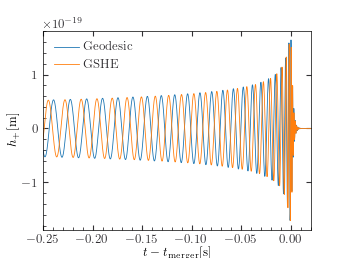

In [94]:
custom_mplstyle()

plt.figure()

plt.plot(thplus.sample_times, thplus.data, label="Geodesic")
plt.plot(thplus_gshe.sample_times, thplus_gshe.data, label="GSHE")


plt.legend()
plt.xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
plt.ylabel(r"$h_{\rm +} [\mathrm{m}]$")
plt.xlim(-0.25, 0.02)
plt.savefig("/Users/richard/Downloads/hp_example.pdf", bbox_inches="tight")
plt.show()

# Strain plot

In [95]:
Fplus = -0.38
Fcross = 0.71

strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

<IPython.core.display.Javascript object>


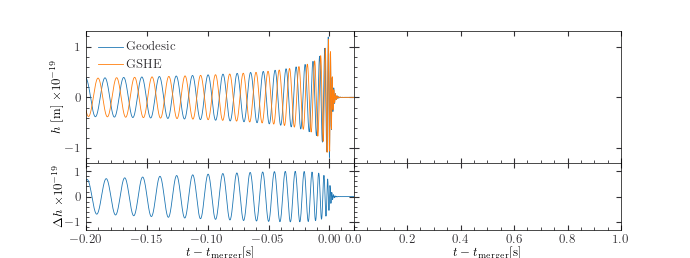

In [96]:
def ylabel_with_offset(ax, label):
    ax.yaxis.offsetText.set_visible(False)
    offset = ax.yaxis.get_major_formatter().get_offset()
    ax.set_ylabel(r"{} {}".format(label, offset))

custom_mplstyle()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.45*2, 0.75*3.45),
                         sharex='col', sharey=True, gridspec_kw={'height_ratios': [1, 0.5]})
fig.subplots_adjust(hspace=0, wspace=0.0)

axes[0, 0].plot(strain.sample_times, strain, label="Geodesic")
axes[0, 0].plot(strain_gshe.sample_times, strain_gshe, label="GSHE")
axes[1, 0].plot(strain.sample_times, strain - strain_gshe)



axes[0,0].legend()

plt.savefig("/Users/richard/Downloads/_tmp.png")
axes[1,0].set_xlim(-0.2, 0.02)

    
ylabel_with_offset(axes[0, 0], r"$h~[\mathrm{{m}}]$")
ylabel_with_offset(axes[1, 0], r"$\Delta h$")
for i in range(2):
    axes[1, i].set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")


plt.savefig("/Users/richard/Downloads/strains.pdf", dpi=300, bbox_inches="tight")
plt.show()

Also show the frequency-domain waveform?